# NLP COMMENTS ASSIGNMENT

This work has been carried out by:


*   María Blanco González-Mohíno
*   Pablo Velasco Crespo
*   José Alberto Seco Sánchez-Camacho
*   Adrián Ruíz Esteban

# Data Load


In [ ]:
#!wget https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/comments.pkl
#!wget https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/df_tfidf.pkl
#!wget https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/df_ngrams.pkl
#!wget https://github.com/MariaBlancoGonzalez/Machine-Learning-22/raw/main/data/processed/df_ngrams_pos.pkl

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import svm
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
from math import ceil

In [ ]:
comments = pd.read_pickle('comments.pkl')
comments.head(2)

,class,text
0,Auto,I have recently purchased a J30T with moderat...
1,Camera,I bought this product because I need instant ...
2,Auto,I have owned my Buick since 53000 km and I am...
3,Camera,This was my first Digital camera so I did qui...
4,Camera,Minolta DiMAGE 7Hi is in a digital SLR with 5...
5,Auto,I had a 1984 Saab a 1996 Saab and now a 1999...


In [ ]:
df_tfidf = pd.read_pickle('df_tfidf.pkl')
df_tfidf.head(2)

In [ ]:
df_ngrams = pd.read_pickle('df_ngrams.pkl')
df_ngrams.head(2)

In [ ]:
df_ngrams_pos = pd.read_pickle('df_ngrams_pos.pkl')
df_ngrams_pos.head(2)

# Model

## TFIDF

### Feature selection

In [ ]:
X_clf = df_tfidf

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

y_clf

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1,

K-best selection

In [ ]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

100% of features: 11736
 70% of features: 8216


In [ ]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_clf_kBest.shape

(600, 3520)

### Classification algorithm: SVM

In [ ]:
type(X_clf_kBest)

numpy.ndarray

In [ ]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,3480,3481,3482,3483,3484,3485,3486,3487,3488,3489,3490,3491,3492,3493,3494,3495,3496,3497,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507,3508,3509,3510,3511,3512,3513,3514,3515,3516,3517,3518,3519
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.067087,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.293617,0.164229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.3)

In [ ]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=3)
results = clf.fit(X_train, y_train)
results

GridSearchCV(cv=3, estimator=SVC(), param_grid={'kernel': ('linear', 'rbf')})

In [ ]:
print(results.best_score_, results.best_params_)

1.0 {'kernel': 'linear'}


In [ ]:
y_pred = results.predict(X_test)

In [ ]:

tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

71 0 0 109


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


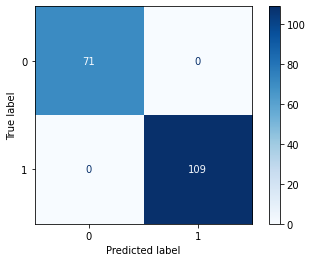

In [ ]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

## TFIDF - N-grams

### Feature selection

In [ ]:
X_clf = comments_df_ngrams

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

X_clf 

,00,00 00,00 00 from,00 649,00 649 00,00 95,00 95 from,00 after,00 after bringing,00 and,00 and 100,00 and headed,00 and it,00 and wa,00 bottom,00 bottom line,00 but,00 but believe,00 but since,00 cad,00 cad the,00 camera,00 camera in,00 canon,00 canon powershot,00 clearance,00 clearance to,00 digital,00 digital camera,00 for,00 for it,00 for the,00 for this,00 from,00 from brandenburkhart,00 from www,00 give,00 give or,00 here,00 here my,...,zoomey camera cropping,zooming,zooming ability,zooming ability of,zooming after,zooming after you,zooming capability,zooming capability of,zooming etc,zooming etc very,zooming finder,zooming finder and,zooming flash,zooming flash head,zooming in,zooming in and,zooming in film,zooming in from,zooming in on,zooming in the,zooming need,zooming need not,zooming optical,zooming optical now,zooming ratio,zooming ratio with,zooming will,zooming will undermine,zx2,zx2 because,zx2 because of,zx2 bought,zx2 bought my,zx2 for,zx2 for single,zx2 new,zx2 new after,zx3,zx3 where,zx3 where lauded
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
596,0.024677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.037985,0.0,0.0,0.043997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
597,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

100% of features: 365891
 70% of features: 256124


In [ ]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
X_clf_kBest.shape

(600, 109767)

### Classification algorithm: SVM

In [ ]:
type(X_clf_kBest)

numpy.ndarray

In [ ]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,109727,109728,109729,109730,109731,109732,109733,109734,109735,109736,109737,109738,109739,109740,109741,109742,109743,109744,109745,109746,109747,109748,109749,109750,109751,109752,109753,109754,109755,109756,109757,109758,109759,109760,109761,109762,109763,109764,109765,109766
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.3)

In [ ]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=3)
results = clf.fit(X_train, y_train)
results

GridSearchCV(cv=3, estimator=SVC(), param_grid={'kernel': ('linear', 'rbf')})

In [ ]:
print(results.best_score_, results.best_params_)

1.0 {'kernel': 'linear'}


In [ ]:
y_pred = results.predict(X_test)

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

71 0 0 109


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


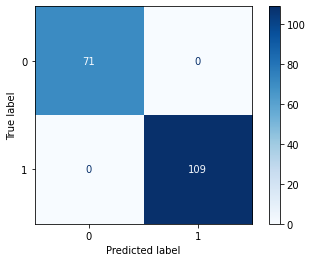

In [ ]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()

## TFIDF - N-grams - Pos tagging

### Feature selection

In [ ]:
X_clf = df_ngrams_pos

y_clf = comments['class']

y_clf = np.where(y_clf == 'Auto', 0, y_clf)
y_clf = np.where(y_clf == 'Camera', 1, y_clf)
y_clf = y_clf.astype('int')

X_clf

In [ ]:
lenght = len(X_clf.columns)
rest_pertcentage = ceil(0.7*len(X_clf.columns))
th_percentage = lenght - rest_pertcentage
print('100% of features: {}\n 70% of features: {}'.format(lenght, rest_pertcentage))

In [ ]:
X_clf_kBest=SelectKBest(score_func=chi2,k=th_percentage).fit_transform(X_clf,y_clf)
X_clf_kBest

In [ ]:
X_clf_kBest.shape

### Classification algorithm: SVM

In [ ]:
type(X_clf_kBest)

In [ ]:
X_clf_train = pd.DataFrame(X_clf_kBest)
X_clf_train.head(2)

In [ ]:
X = X_clf_train[list(X_clf_train.columns)]
y = pd.Series(y_clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.3)

In [ ]:
parameters = {'kernel':('linear','rbf')}

svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=3)
results = clf.fit(X_train, y_train)
results

In [ ]:
print(results.best_score_, results.best_params_)

In [ ]:
y_pred = results.predict(X_test)

In [ ]:
tn, fp, fn, tp  = confusion_matrix(y_test, y_pred).ravel()
print(tn, fp, fn, tp)

In [ ]:
disp = plot_confusion_matrix(results, X_test, y_test,cmap=plt.cm.Blues) 
plt.show()